In [17]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import os
import glob
import pickle
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt
plt.tight_layout()
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
from sklearn.linear_model import LinearRegression

<Figure size 432x288 with 0 Axes>

## Read the final saved dataframes containing features and targets

In [19]:
########################   SUBSTITUTE THE PATH HERE TO PATH OF FINAL_TRAIN_DATAFRAME_PICKLE_FILE ############################
with open('/home/moningi-srija/Desktop/gpu_downloads/final_train.pkl', 'rb') as handle:
    df_train = pickle.load(handle)
########################   SUBSTITUTE THE PATH HERE TO PATH OF FINAL_TEST_DATAFRAME_PICKLE_FILE ############################
with open('/home/moningi-srija/Desktop/gpu_downloads/final_test.pkl', 'rb') as handle:
    df_test = pickle.load(handle)

print(df_train.shape, df_test.shape)

(75, 36) (25, 36)


In [20]:
df_train.head()

,feature_overall,feature_revenue,feature_profit,feature_debt,feature_dividend,feature_management,feature_research,feature_customerbase,feature_industry,feature_competition,meta_symbol,meta_report_date,era,symbol,target_max,target_min,target_3m,target_6m,target_9m,target_12m,sp500_max,sp500_min,sp500_3m,sp500_6m,sp500_9m,sp500_12m,report_date,start_date,end_date,target_max_normalised,target_min_normalised,target_3m_normalised,target_6m_normalised,target_9m_normalised,target_12m_normalised,target_ml
0,0.75,0.80,0.80,0.90,0.90,1.0,0.85,0.7,0.85,0.80,MANH,2009-02-24,2009,MANH,68.253417,-2.486305,25.684931,30.342467,65.068491,67.465754,51.696787,-5.468037,20.921057,36.303014,44.970309,46.050235,2009-02-24,2009-02-26,2010-02-17,-0.024786,0.027147,0.017703,-0.268732,0.288362,0.174361,0.50
1,0.85,0.80,0.80,0.80,0.80,0.8,0.00,0.7,0.75,0.85,ORLY,2014-02-28,2014,ORLY,36.840331,-4.648191,-2.104154,3.209152,19.314498,38.086413,13.760212,-0.041845,4.217300,8.540795,12.304080,14.527051,2014-02-28,2014-03-02,2015-02-25,0.900981,0.328414,-0.376676,-0.135433,0.665460,1.117033,1.00
2,0.70,0.85,0.80,0.75,0.80,0.8,0.80,0.8,0.80,0.80,USNA,2011-03-14,2011,USNA,15.030114,-25.104216,-18.644579,-20.090361,-8.162653,12.349393,8.811562,-10.576400,2.465628,-6.684012,-1.623865,9.086783,2011-03-14,2011-03-16,2012-03-12,0.022483,-0.416383,-1.682992,-0.652775,-0.153471,0.317753,0.75
3,0.80,0.70,0.85,1.00,0.75,0.0,0.00,0.8,0.85,0.80,ROST,2005-04-14,2005,ROST,9.967186,-15.062060,-1.819556,-7.971957,10.445306,8.106115,13.884621,0.589927,7.026302,2.766198,12.540355,13.145083,2005-04-14,2005-04-16,2006-04-10,-0.720182,-0.576636,-0.471140,-0.989240,-0.008112,-0.359093,0.25
4,0.70,0.90,0.75,0.80,0.85,0.0,0.00,0.7,0.75,0.80,RYN,2015-03-02,2015,RYN,0.027741,-26.997703,-5.175752,-13.951677,-7.773064,-16.474144,1.312977,-11.149138,0.527515,-6.020880,-0.401230,-7.170733,2015-03-02,2015-03-04,2016-02-27,-1.437846,-0.538882,-0.675743,-0.680767,-0.420168,-0.437672,0.25


In [21]:
sorted(df_train.era.unique())

[2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017]

In [22]:
sorted(df_test['era'].unique())

[2004, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [23]:
feature_cols = [c for c in df_train.columns if c.startswith('feature')]
len(feature_cols)

10

In [24]:
print(df_train.columns)

Index(['feature_overall', 'feature_revenue', 'feature_profit', 'feature_debt', 'feature_dividend', 'feature_management', 'feature_research', 'feature_customerbase', 'feature_industry', 'feature_competition', 'meta_symbol', 'meta_report_date', 'era', 'symbol', 'target_max', 'target_min', 'target_3m', 'target_6m', 'target_9m', 'target_12m', 'sp500_max', 'sp500_min', 'sp500_3m', 'sp500_6m', 'sp500_9m', 'sp500_12m', 'report_date', 'start_date', 'end_date', 'target_max_normalised', 'target_min_normalised', 'target_3m_normalised', 'target_6m_normalised', 'target_9m_normalised', 'target_12m_normalised', 'target_ml'], dtype='object')


In [25]:
# target_custom_22 corresponds to target created from 12 month normalised returns per year (aka era) and then binned
# refer make_targets.py for more details
df_train['target_12m_normalised'].unique()

array([ 0.1743608 ,  1.11703289,  0.31775255, -0.35909322, -0.43767181,
       -0.69322514,  0.4531158 , -2.19838887,  1.77297298, -0.59795176,
       -0.64224267, -1.37494058,  1.33884802, -0.13092665,  0.1520086 ,
        0.28458574,  0.91029971, -0.0705775 ,  0.84837993,  1.26192231,
       -0.29260908, -2.48710363, -0.57499659,  0.27202076,  1.53977723,
       -1.3880682 ,  0.63728216,  0.06746425,  1.16188294, -0.11038049,
       -0.22460881, -1.12155702,  0.2903794 ,  0.59817412, -1.09800124,
        0.68816933,  0.54525678,  0.06968492,  0.38713711,  0.31948256,
       -0.18269319, -1.03609198,  1.90693765, -1.32526621, -0.40895081,
        2.13328571,  1.42627881, -0.40001253, -0.8122178 ,  0.39198775,
       -0.36782398,  0.00721486,  0.45009362,  0.67197036,  1.26405527,
        0.1075349 ,  0.20050548,  0.74510178,  0.03895857, -1.60291413,
       -2.30641096,  0.39443951, -1.33084125,  0.73364096, -0.27399182,
       -0.89489356,  0.41043191, -1.40939939,  0.74529156, -0.43

In [26]:
# target_custom_2 corresponds to target created from max normalised returns in the span of 12 months per year (aka era) and then binned
# refer make_targets.py for more details
df_train['target_max_normalised'].unique()

array([-0.02478559,  0.90098051,  0.02248287, -0.72018165, -1.43784617,
       -0.81898356,  0.15616259, -0.60529276,  1.52822212, -0.95723546,
       -1.03159926, -1.11744599,  0.87961157,  0.50468222, -0.1629597 ,
        0.151213  ,  0.91029971, -0.15663461,  0.59535033,  1.11618937,
       -0.24386984, -0.77449798, -1.10928008,  0.39864946,  1.46702229,
        0.550217  ,  1.44573886, -0.00854543,  0.67711155,  0.01124072,
       -0.14709493, -0.91496436,  0.17179638,  0.40178087, -1.17260574,
       -0.36592227, -0.27456059, -0.14090212, -0.03372785,  0.10920048,
       -0.5077511 , -1.93212606,  1.54719892, -0.76728891, -0.88153133,
        2.02496084,  1.25816156,  1.11981948, -1.05073788,  0.4385515 ,
       -1.52461858, -0.4899382 ,  0.20697395,  0.2454736 ,  0.38123959,
       -0.1540983 ,  0.06319352,  1.22508976,  0.29349294, -0.3048009 ,
       -2.39438708,  0.26165748, -0.96926593,  0.68904985, -0.06365816,
       -1.57572361,  0.0259246 , -0.17089133,  0.61077738, -1.12

**Note**: '12 month normalised' returns refers to returns during the period between 2 successive annual report filings.
'max normalised returns' also refers to the same period but calculates returns from the annual report date to the date 
when max return ($98^{th}$ percentile) was achieved during that period

## Linear Regression Model

In [27]:
reg_12m = LinearRegression().fit(df_train[feature_cols], 
                                           df_train['target_12m_normalised'])
reg_max = LinearRegression().fit(df_train[feature_cols], 
                                           df_train['target_max_normalised'])

df_test['pred_reg_12m'] = reg_12m.predict(df_test[feature_cols])
df_test['pred_reg_max'] = reg_max.predict(df_test[feature_cols])

In [28]:
reg_12m.coef_

array([ 4.14437232, -0.15734054,  0.41128531, -0.63750675, -0.42285656,
       -0.31847795,  0.30868798, -1.40536744,  0.2170353 ,  0.27620669])

In [13]:
reg_max.coef_

array([ 4.41300647e+00,  1.68551110e-01,  6.37663943e-01, -6.35944332e-01,
       -5.80236667e-01, -9.97205465e-02, -3.40198511e-03, -1.32017599e+00,
       -3.13224960e+00,  3.43994822e-02])

In [29]:
df_test['id'] = range(1, len(df_test) + 1)
print(df_test)

    feature_overall  feature_revenue  feature_profit  feature_debt  feature_dividend  feature_management  feature_research  feature_customerbase  feature_industry  feature_competition meta_symbol meta_report_date   era symbol  target_max  target_min  target_3m  target_6m  target_9m  target_12m  sp500_max  sp500_min   sp500_3m   sp500_6m   sp500_9m  sp500_12m report_date  start_date    end_date  target_max_normalised  target_min_normalised  target_3m_normalised  target_6m_normalised  target_9m_normalised  target_12m_normalised  target_ml  pred_reg_12m  pred_reg_max  id
0              0.75             0.80            0.75          0.80              0.80                0.70              0.70                  0.80              0.80                 0.80        COLB       2006-03-07  2006   COLB    6.805395   -9.365731  -3.236279  -5.427381  -0.064809    1.391855  14.391963  -2.740042  -0.658686   3.048193   9.784393  10.579059  2006-03-07  2006-03-09  2007-02-28              -1.008238      

## Analyse top predicted stocks

In [31]:
def calc_returns(df_test, top_k, returns_col, pred_col):
    '''
    Function to calculate the mean returns across all years.
    Finds out the top predicted stocks each year and then computes mean returns.
    Args:
        df_test: Test df containing the return column and the predicted column.
        top_k: Top 'k' stocks to select based on 'pred_col'.
        returns_col: Column containing the raw returns for that period.
        pred_col: Column containing the prediction of the ML model.
    Returns:
        Dictionary with Mean returns of predicted stocks and the S&P500 index for the same duration.
        Results are averaged across all years.
    '''
    ret_dict = {}
    #Get list of top_k predicted stocks for each year (aka era)
    top_pred_id_list = list(df_test.groupby('era', group_keys=False).apply(lambda d: d.sort_values(by=pred_col, ascending=False).iloc[:top_k]['id']))
    
    #Filter the df to contain only top_k predicted stocks
    df_toppred = df_test.loc[lambda x: x['id'].isin(top_pred_id_list)].sort_values(by='era')

    #Compute the average returns in each year. The resulting df will contain percent returns for each year. 
    returns_agg_df = df_toppred.loc[:, ['era', 'sp500_{}'.format(returns_col), 'target_{}'.format(returns_col)]].groupby('era').agg('mean')

    ret_dict['top_k'] = top_k
    #Calculate average percent returns across all years.
    ret_dict['sp500_mean'] = returns_agg_df['sp500_{}'.format(returns_col)].mean()
    ret_dict['gpt_mean'] = returns_agg_df['target_{}'.format(returns_col)].mean()
    return ret_dict

In [32]:
#Find top stocks based on prediction by 'reg_12m' model.
#Calculate returns for entire 12 month duration
df_eval_12m = pd.DataFrame()

#k denotes the number of top stocks to be selected per year.
for k in range(1, 6):
    curr_df = pd.DataFrame.from_dict(calc_returns(df_test, k, returns_col='12m', pred_col='pred_reg_12m'), orient='index').T
    curr_df.set_index('top_k', inplace=True)
    df_eval_12m = pd.concat([df_eval_12m, curr_df], ignore_index=False)

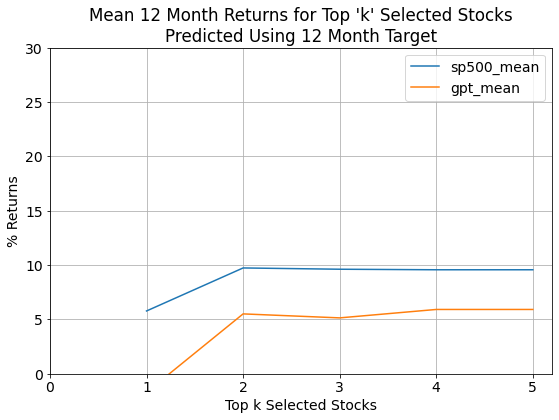

In [45]:
df_eval_12m.loc[:, ['sp500_mean', 'gpt_mean']].plot(figsize=(9,6))
plt.grid()
plt.title("Mean 12 Month Returns for Top 'k' Selected Stocks\nPredicted Using 12 Month Target")
plt.ylabel('% Returns')
plt.ylim(0, 30)
plt.xticks(range(0, 6, 1))
plt.xlabel('Top k Selected Stocks')
########################   SUBSTITUTE THE PATH HERE TO PATH OF PLOTS_SAVE_DIRECTORY ############################
plt.savefig("plots/12mReturns_12mTarget.png", dpi=300)

In [34]:
#Find top stocks based on prediction by 'reg_max' model.
#Calculate returns for entire 12 month duration
df_eval_max = pd.DataFrame()

#k denotes the number of top stocks to be selected per year.
for k in range(1, 11):
    curr_df = pd.DataFrame.from_dict(calc_returns(df_test, k, returns_col='12m', pred_col='pred_reg_max'), orient='index').T
    curr_df.set_index('top_k', inplace=True)
    df_eval_max = pd.concat([df_eval_max, curr_df], ignore_index=False)

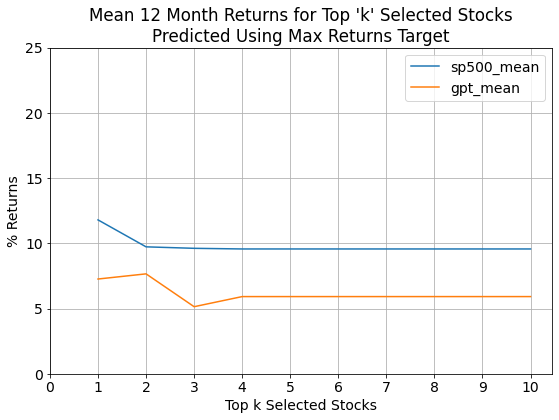

In [35]:
df_eval_max.loc[:, ['sp500_mean', 'gpt_mean']].plot(figsize=(9,6))
plt.grid()
plt.title("Mean 12 Month Returns for Top 'k' Selected Stocks\nPredicted Using Max Returns Target")
plt.ylabel('% Returns')
plt.ylim(0, 25)
plt.xticks(range(0, 11, 1))
plt.xlabel('Top k Selected Stocks')
########################   SUBSTITUTE THE PATH HERE TO PATH OF PLOTS_SAVE_DIRECTORY ############################
plt.savefig("plots/12mReturns_maxTarget.png", dpi=300)

## Calculate Value of $1 invested at start of 2018

In [40]:
def plot_accumulated_value(df_test, top_k, returns_col, pred_col, title):
    top_pred_id_list = list(df_test.groupby('era', group_keys=False).apply(lambda d: d.sort_values(by=pred_col, ascending=False)\
                                                                           .iloc[:top_k]['id']))
    df_toppred = df_test.loc[lambda x: x['id'].isin(top_pred_id_list)].sort_values(by='era')

    account_sp500 = [1]
    account_gpt = [1]
    for era_tuple in df_toppred.groupby('era'):
        era = era_tuple[0]
        era_df = era_tuple[1]
        sp500_returns = era_df['sp500_{}'.format(returns_col)].mean()
        gpt_returns = era_df['target_{}'.format(returns_col)].mean()
        #Compute new account value based on current percent returns
        new_account_sp500 = account_sp500[-1] * (1 + sp500_returns/100.0)
        new_account_gpt = account_gpt[-1] * (1 + gpt_returns/100.0)
        account_sp500.append(new_account_sp500)
        account_gpt.append(new_account_gpt)

    fig, ax = plt.subplots(1,1, figsize=(9,7))
    ax.plot(range(2010, 2024), account_sp500, label='S&P 500')
    ax.plot(range(2010, 2024), account_gpt, label='GPT')
    ax.set_ylabel('Cumulative Amount')
    ax.set_xlabel('Year')
    ax.set_title(title)
    ax.grid()
    ax.legend()
    return fig, ax

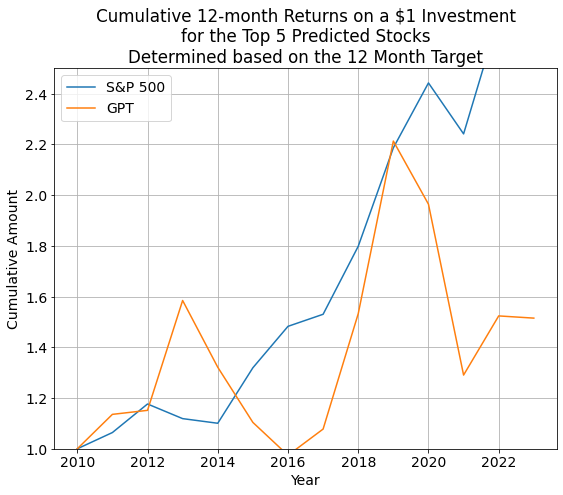

In [41]:
fig, ax = plot_accumulated_value(df_test, 5, returns_col='12m', pred_col='pred_reg_12m',
                                title='Cumulative 12-month Returns on a $1 Investment\nfor the Top 5 Predicted Stocks\nDetermined based on the 12 Month Target')
ax.set_ylim(1, 2.5)
ax.legend(loc='upper left')
########################   SUBSTITUTE THE PATH HERE TO PATH OF PLOTS_SAVE_DIRECTORY ############################
fig.savefig('plots/cumulative_12mReturns_12mTarget.png', dpi=300)

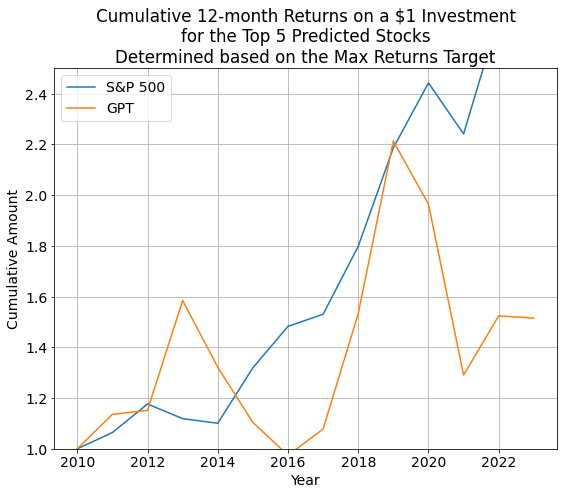

In [42]:
fig, ax = plot_accumulated_value(df_test, 5, returns_col='12m', pred_col='pred_reg_max',
                                title='Cumulative 12-month Returns on a $1 Investment\nfor the Top 5 Predicted Stocks\nDetermined based on the Max Returns Target')
ax.set_ylim(1, 2.5)
ax.legend(loc='upper left')
########################   SUBSTITUTE THE PATH HERE TO PATH OF PLOTS_SAVE_DIRECTORY ############################
fig.savefig('plots/cumulative_12mReturns_maxTarget.png', dpi=300)

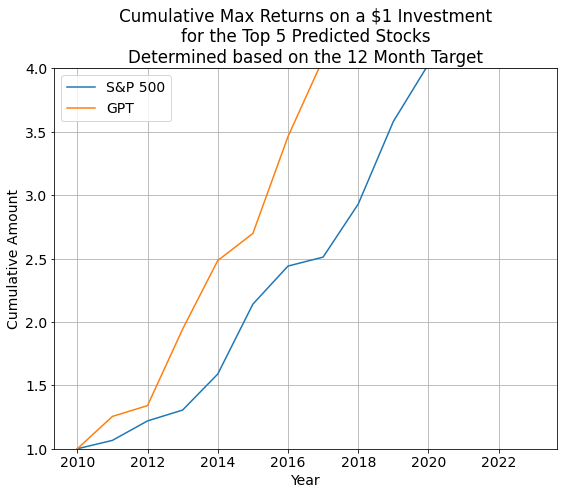

In [43]:
fig, ax = plot_accumulated_value(df_test, 5, returns_col='max', pred_col='pred_reg_12m',
                                title='Cumulative Max Returns on a $1 Investment\nfor the Top 5 Predicted Stocks\nDetermined based on the 12 Month Target')
ax.set_ylim(1, 4)
ax.legend(loc='upper left')
########################   SUBSTITUTE THE PATH HERE TO PATH OF PLOTS_SAVE_DIRECTORY ############################
fig.savefig('plots/cumulative_maxReturns_12mTarget.png', dpi=300)

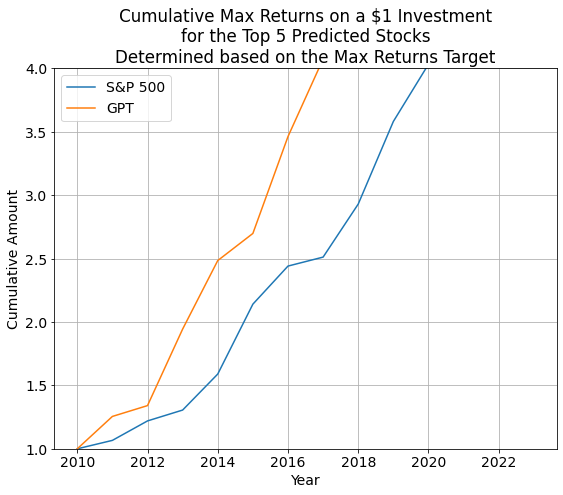

In [44]:
fig, ax = plot_accumulated_value(df_test, 5, returns_col='max', pred_col='pred_reg_max',
                                title='Cumulative Max Returns on a $1 Investment\nfor the Top 5 Predicted Stocks\nDetermined based on the Max Returns Target')
ax.set_ylim(1, 4)
ax.legend(loc='upper left')
########################   SUBSTITUTE THE PATH HERE TO PATH OF PLOTS_SAVE_DIRECTORY ############################
fig.savefig('plots/cumulative_maxReturns_maxTarget.png', dpi=300)